In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn import neighbors

# Anyone against the idea of using external libraries?? If someone has a better idea, im open to suggestion
import glob

from datetime import datetime, date

In [3]:
def computeHoG(image, winSize, blockSize, blockStride, cellSize,
                               nbins, RESIZE_DIM, cell_size, block_size):
    
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    n_cells = (RESIZE_DIM // cell_size[0], RESIZE_DIM // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(image)
    hog_feats = hog_feats.reshape(n_cells[1]-block_size[1]+1,
                                  n_cells[0]-block_size[0]+1,
                                  block_size[0], block_size[1], nbins)
    hog_feats = hog_feats.transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,
    #for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count

    gradients = gradients.reshape((1, -1))
    return gradients

def resizeImage(image, dimension):
    imy, imx = image.shape[0:2]
    M = np.float32([[dimension/imx, 0, 0], [0, dimension/imy, 0]])
    image = cv2.warpAffine(image, M, (RESIZE_DIM, RESIZE_DIM))
    return image

In [17]:
#displaay
startGlobal = datetime.time(datetime.now())

#Variable initialization
# categoriesTest  = ["car","background","pickup_truck","articulated_truck","bus","work_van","pedestrian",
#                    "single_unit_truck","bicycle","motorcycle", "non-motorized_vehicle"]

# #testing
categoriesTest  = [
#     "car",
#     "background",
#     "pickup_truck",
#     "articulated_truck",
#     "bus",
    "work_van",
    "pedestrian",
    "single_unit_truck",
    "bicycle",
    "motorcycle",
    "non-motorized_vehicle"]
#endTesting
#^We notice that runtime is minimized of operations occur on the largest categories first
numCategories = len(categoriesTest)

#TEMP
sumIm = 0
for i in range(numCategories):
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])
    numImages = len(glob.glob(path))
    sumIm = sumIm + numImages
#End TEMP

RESIZE_DIM = 128
# totalNumIm = 519164 #MAY GIVE MEMORY ERROR
#testing
totalNumIm = sumIm
#End testing
globalImCtr = 0

#HoG variables
#Raw variables
cell_size = (4,4)
block_size = (4, 4)

#variables for computation
winSize = (RESIZE_DIM // cell_size[1] * cell_size[1], RESIZE_DIM // cell_size[0] * cell_size[0] )
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
blockStride = (cell_size[1], cell_size[0])
cellSize = (cell_size[1], cell_size[0])
nbins = 8
#End HoG variables

totalNumFeatures = RESIZE_DIM // cell_size[1] * RESIZE_DIM // cell_size[0] * nbins

#array initialization
labelsArray = np.zeros(totalNumIm, dtype=np.int)
featuresArray = np.zeros((totalNumIm, totalNumFeatures))
indexArray = np.arange(totalNumIm, dtype=np.int)
np.random.shuffle(indexArray)         

# Read input images category by category
for i in range(numCategories):
    start = datetime.time(datetime.now())

    #specifying path to images
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])

    #Variable initializations
    categoryImgCnt = 0
    nextPctg = 5
    numImages = len(glob.glob(path))

    #display
    print("Loading Images for category:    >>>" + categoriesTest[i] + "<<<    " + str(numImages) + " images")
    print("    Percentage Completed: 0%-", end='')

    # for each image in the category folder
    for file in glob.glob(path):
        #read, convert color, get features, stor info
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #resizing IF NECESSARY
        #TRY to do HoG without resizing image. to be discussed
        image = resizeImage(image, RESIZE_DIM)
        #end resize
        
        #Computing features
        #HoG features
        gradients = computeHoG(image, winSize, blockSize, blockStride, cellSize,
                               nbins, RESIZE_DIM, cell_size, block_size)

        randomIndex = indexArray[globalImCtr]
        featuresArray[randomIndex] = gradients
        labelsArray[randomIndex] = i
        #End Feature computation
        
        #variable update
        globalImCtr = globalImCtr + 1
        categoryImgCnt = categoryImgCnt + 1
        
        #display
        if (int(categoryImgCnt*100/numImages)) == nextPctg:
            print(str(nextPctg) + "%", end='')
            if nextPctg != 100 : print("-", end='')
            nextPctg = nextPctg + 5
    #display        
    print("")
    end = datetime.time(datetime.now())
    print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))

#display
endGlobal = datetime.time(datetime.now())
duration = datetime.combine(date.today(), endGlobal) - datetime.combine(date.today(), startGlobal)
print(">Total duration: " + str(duration))
print(labelsArray[:100])

Loading Images for category:    >>>work_van<<<    9679 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:01:08.910110
Loading Images for category:    >>>pedestrian<<<    6262 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:41.057297
Loading Images for category:    >>>single_unit_truck<<<    5120 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:38.888335
Loading Images for category:    >>>bicycle<<<    2284 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:12.553525
Loading Images for category:    >>>motorcycle<<<    1982 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:0

classification begins
classification finished


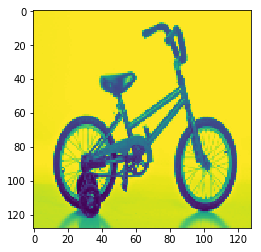

The classifier classifies the test image as motorcycle


In [16]:
#TODO K-fold cross-validation

#TESTING
print("classification begins")
classifier = neighbors.KNeighborsClassifier(3)
classifier.fit(featuresArray, labelsArray)
print("classification finished")
#Takes long because too many features per image (cuz image large)

#Bike image
# testIm = cv2.imread("MIO-TCD-Classification/test/106330631.jpg")
testIm = cv2.imread("MIO-TCD-Classification/6-low-res.jpg")
testIm = cv2.cvtColor(testIm, cv2.COLOR_BGR2GRAY)
#Resize
testIm = resizeImage(testIm, RESIZE_DIM)
#End resize

#HoG features
gradients = computeHoG(testIm, winSize, blockSize, blockStride, cellSize,
                               nbins, RESIZE_DIM, cell_size, block_size)

plt.imshow(testIm)
plt.show();

#PREDICTION
prediction = classifier.predict(gradients)[0]
print("The classifier classifies the test image as " + str(categoriesTest[prediction]))


#END TESTING

In [ ]:
def HoG(input_list, cell_size, block_size, nbins):    
    output_list = list()
    for category in range(0, len(input_list)):
        for index in range (0,len(input_list[category][0])):
            
            img = cv2.cvtColor(np.array(input_list[category][0][index]), cv2.COLOR_BGR2GRAY)
            
            #Calculate parameters value for HOGDescriptor()
            winSize = (img.shape[1] // cell_size[1] * cell_size[1], img.shape[0] // cell_size[0] * cell_size[0])
            blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
            blockStride = (cell_size[1], cell_size[0])
            cellSize = (cell_size[1], cell_size[0])
            
            # create HoG Object
            hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
            
            n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
            
            # Compute HoG features
            hog_feats = hog.compute(img)
            hog_feats = hog_feats.reshape(n_cells[1]-block_size[1]+1, n_cells[0]-block_size[0]+1, block_size[0], block_size[1], nbins)
            hog_feats = hog_feats.transpose((1, 0, 2, 3, 4))  # index blocks by rows first
            
            # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
            # Indexing is by rows then columns.
            
            # computation for BlockNorm
            gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
            cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)
            
            for off_y in range(block_size[0]):
                for off_x in range(block_size[1]):
                    gradients[off_y:n_cells[0] - block_size[0] + off_y + 1, off_x:n_cells[1] - block_size[1] + off_x + 1] += hog_feats[:, :, off_y, off_x, :]
                    cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1, off_x:n_cells[1] - block_size[1] + off_x + 1] += 1
            
            # Average gradients
            gradients /= cell_count
            
            output = gradients.reshape((1, -1))
            output_list.append([output[0], category]) #[HoG, Category]
            
            """
            # Preview
            plt.figure(figsize = (10,10))
            plt.subplot(121)
            plt.imshow(img, cmap='gray')
            plt.title("Original Image"), plt.xticks([]), plt.yticks([])
            
            bin = 0  # angle is 360 / nbins * direction
            plt.subplot(122)
            plt.pcolor(gradients[:, :, bin])
            plt.gca().invert_yaxis()
            plt.gca().set_aspect('equal', adjustable='box')
            plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
            plt.colorbar()
            plt.show()
            print()
            """
    
    return output_list

In [3]:
# Compute HoG features for the training images

# training_output_list format: [[HoG, category], [HoG, category], [HoG, category], ...]
training_output_list  = list()
training_output_list = HoG(Input, (4,4), (64,64), 8) # TODO Figure out the best param during optimization

In [4]:
from sklearn import svm
from sklearn import datasets

# reformat data
data = np.array([[0 for i in range(len(training_output_list[0][0]))] for j in range(len(training_output_list))])
target = np.array([0 for i in range(len(training_output_list))])

for i in range(0, len(training_output_list)):
    data[i][:] = training_output_list[i][0]
    target[i] = training_output_list[i][1]

print(data.shape)
print(target.shape)

clf = svm.SVC(gamma=0.001, C=100.) #
# training, let's us all the data but the first 4 instances
clf.fit(data[4:], target[4:])

# now predict the label for the first 4 instances
print("Predicted Label:", clf.predict(data[:4]))
print("Actual Label:", target[:4])

(4025, 32768)
(4025,)
Predicted Label: [2 2 2 2]
Actual Label: [0 0 0 0]
